In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt

<font size=6>**Introduction to Bayesian Statistics**</font>


# 1. The problem: Counting photons...

Typically, an X-ray imaging observation gives a collection of **events**: coordinates and energies of **individual photons** detected by the telescope. Essentially, we count photons, and this is why we usually refer to the photons as **counts**, while the **count rate** informs us about the number of photons per second. In general, the count rate scales with the flux of the field (or source) in the energy band of the telescope during the observation.

<table><tr>
<td> <img src="images/NGC1482_opt.jpg" alt="Drawing" style="height:400px;"/> </td>
<td> <img src="images/NGC1482.png" alt="Drawing" style="height: 400px;"/> </td>
</tr></table>


Using **source detection algorithms** we group photons together and generate a list of sources and the photons we got from each - namely, the *source region*. For a given source, the integrated energy of the photons from its source region gives us an estimate on the energy collected from the telescope. Of course, the response of the detector and absorption effects should be accounted for. Having many counts allows us to fit for the spectrum of the source. Modeling the detector properties, the intergalactic absorption and the spectra allows us to measure the *bolometric* flux of the source - the flux as if we could observe the source with a perfect detector. Provided we know the distance of the source we can convert from flux to luminosity... an intrinsic property of the source (which is what we usually care for)!

## 1.1. How many counts are we going to get?

<font size=3><u>**In-class discussion: If each photon count during the exposure (e.g., 50 ks) corresponds to luminosity $10^{38}\,\rm erg\,s^{-1}$, and our souce is $5\times 10^{38}\,\rm erg\,s^{-1}$, what is **on average** the number of counts we will measure?**</u><font>

_Discuss with your teammate, then report._

<details>
<summary><b>[Spoiler]</b></summary>
<br>
Simply dividing we get the number of counts!
<br>

In [7]:
COUNT_TO_LUMINOSITY = 1.0e38  # in erg/s
source_luminosity = 5.0e38    # in erg/s
expected_counts = source_luminosity / COUNT_TO_LUMINOSITY
print(f"Expected counts: {expected_counts:.3f}")

Expected counts: 5.000


<font size=3><u>**In-class discussion: What is the distribution of the potential multiple count measurements?**</u><font>

_Discuss with your teammate, then report._

<details>
<summary><b>[Spoiler]</b></summary>
<br>
It's a counting problem, and we expect that it's measurement is independent (arrivals of photons, multiple experiments), so... it's Poisson!
    
$$\Large P(\textrm{counts} | \textrm{expected}) = P(k | \lambda) = \textrm{Pois}(k; \lambda) = \dfrac{\lambda^k e^{-\lambda}}{k!} $$
<br>

<div class="alert alert-block alert-warning" style="margin-top: 20px">

**Task:**  Select the appropriate distribution and plot it.
</div>

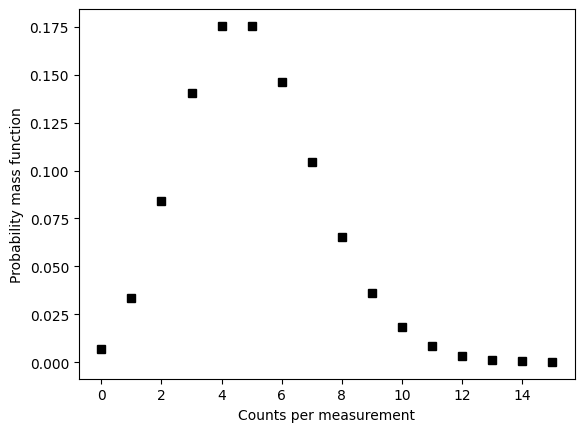

In [8]:
outcomes = np.arange(0, int(expected_counts*3)+1, 1)
pmf = st.poisson(expected_counts).pmf(outcomes)
plt.figure()
plt.plot(outcomes, pmf, "ks")
plt.xlabel("Counts per measurement")
plt.ylabel("Probability mass function")
plt.show()

<font size=3><u>**In-class discussion: What is the uncertainty on the measured counts?**</u><font>

_Discuss with your teammate, then report._

<details>
<summary><b>[Spoiler]</b></summary>
<br>
Since it's Poisson, the standard deviation is the square root of the expected value!
<br>

<div class="alert alert-block alert-warning" style="margin-top: 20px">

**Task:**  Compute the uncertainty on the measured counts using either a formula, or a `scipy` function.
</div>

In [9]:
counts_uncertainty = expected_counts**0.5
print(f"Uncertainty: {counts_uncertainty:.3f}")

Uncertainty: 2.236


## 1.2. Estimating the luminosity of a source


<font size=3><u>**In-class discussion: Let's do the opposite now! We found a source that emitted 5 counts. What is the luminosity of the source?**</u><font>

_Discuss with your teammate, then report._

<details>
<summary><b>[Spoiler]</b></summary>
<br>
The Poisson distribution above peaks at 5 counts, but also for 4 counts. So... if we got 4 counts, 5 would also be a good answer?
There is something weird going on! We have one measurement and we ask a question about the source! Also, we are always going to get integer multiples of the count/luminosty factor this way! But nature doesn't care about the photons we got, how far away we are, etc.
<br>

<div class="alert alert-block alert-warning" style="margin-top: 20px">

**Task:**  Select three offsets, including zero, (can be negative or positive value) around the mean value and inspect the resulting distributions: what do you notice?
</div>

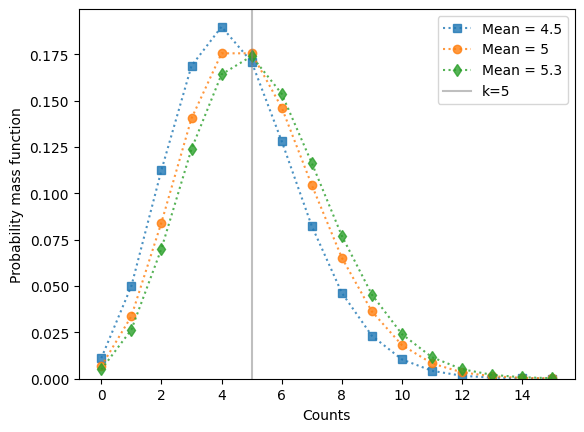

In [10]:
outcomes = np.arange(0, int(expected_counts*3)+1, 1)
plt.figure()
# try different offsets around the expected mean value and plot the PMF
for offset, marker in zip([-0.5, 0.0, 0.3], ["s", "o", "d"]):
    mean = expected_counts + offset
    plt.plot(outcomes, st.poisson(mean).pmf(outcomes), ":", marker=marker, alpha=0.8, label=f"Mean = {mean:.4g}")
plt.axvline(expected_counts, color="0.5", alpha=0.5, label="k=5")
plt.ylim(ymin=0)
plt.legend(loc="upper right")
plt.xlabel("Counts")
plt.ylabel("Probability mass function")
plt.show()

### We have multiple (actually infinite) hypothesis for the source luminosity

Before, we had the source luminosity fixed, and we wondered what we will measure, if repeating the experiment many times! This is the **frequentist approach**. And we also assigned uncertainty in the data!!!

> A frequentist assigns probabilities to data - parameters are fixed. The probability is a *frequency* of data outcomes.

But when asking about the nature of things (like in... all Science except for mathematics), then we are not interested in assigning uncertainty on the data. The data are what they are - also... they might have been fundamentally unique (some experiments cannot be repeated). We need to assign probabilities to the quantity of interest. This is the **Bayesian approach**:

$$\Large P(\textrm{hypothesis} | \textrm{data}) $$

> A Bayesian assigns probabilities to hypotheses. The probability is a *degree of belief* in a value of a parameter.

![image from Sivia](images/Sivia_Logic.png)

# 2. Bayes Theorem: The Foundation of Bayesian Inference

To navigate from what we can model, $P(\textrm{data} | \textrm{hypothesis})$, to what we want to know, $P(\textrm{hypothesis} | \textrm{data})$, we use Bayes Theorem. It arises from the basic rules of probability.

The joint probability of two events (or propositions) A and B occurring, $P(A, B)$, can be written in two ways:

$$\Large P(A, B) = P(A | B) P(B) $$

$$\Large P(A, B) = P(B | A) P(A) $$

Since $P(A,B)$ is the same in both expressions, we can equate them:

$$\Large P(A | B) P(B) = P(B | A) P(A) $$

Rearranging this gives us Bayes Theorem:

$$\Large P(A | B) = \dfrac{P(B | A) P(A)}{P(B)} $$

In the context of data and hypotheses, we write this as:

$$\Large P(\textrm{hypothesis} | \textrm{data}, I) = \dfrac{P(\textrm{data} | \textrm{hypothesis}, I) P(\textrm{hypothesis} | I)}{P(\textrm{data} | I)} $$

Here, $I$ represents all our background information and assumptions.

We made everything conditional to $I$, the **background information**: all relevant knowledge we have about the problem we are solving but are not part of the data or the specific hypothesis being tested.

For example, if we are testing whether a die is fair, the data are a sequence of outcomes (e.g., 1, 6, 3, 5, 3, 1), the hypothesis could be **the probability of rolling a 6 is $p_6$**, and $I$ = $\big\{$ all dice have 6 sides, a fair die has equiprobable sides, the laws of physics as we know them, $\cdots \big\}$.

For brevity, **we usually omit writing the $I$** in the equations, but **its always there**... somewhere in the background!

All the terms of Bayes Theorem have specific names:

*   **Posterior Probability**: $P(\text{hypothesis} | \text{data}, I)$ is the (updated) degree of belief in the hypothesis *after* considering the data.
*   **Likelihood**: $P(\text{data | hypothesis}, I)$ is the probability of observing the data *given* that the hypothesis is true. This is what we often model based on our understanding of the data generation process.
*   **Prior Probability**: $P(\text{hypothesis} | I)$ is the degree of belief in the hypothesis *before* looking at the current data. It encapsulates our previous knowledge, physical constraints, or initial assumptions.
*   **Evidence (or Marginal Likelihood)**: $P(\text{data} | I)$ is the overall probability of observing the data, averaged over all possible hypotheses. It acts as a normalization constant.

> In Bayesian Analysis we assign degrees of belief to hypotheses (prior), which we "update" using experimental data (via the likelihood), to arrive at a new, refined degree of belief in the hypotheses (posterior).

### A Deeper Look at the Components:

**1. The Likelihood $P(\text{data} | \text{hypothesis}, I)$:**
This term quantifies how well our hypothesis explains the observed data. If the data are very probable under the hypothesis, the likelihood is high. If the data are improbable, the likelihood is low. For many problems, we assume a specific mathematical form for the likelihood (e.g., Gaussian, Poisson) based on the nature of the data and the measurement process.

**2. The Prior $P(\text{hypothesis} | I)$:**
The prior represents our state of knowledge about the hypothesis before we consider the current dataset. It can come from previous experiments, theoretical predictions, or fundamental principles. The choice of prior can be influential, especially with limited data, and is a key aspect of Bayesian modeling. We will discuss how to choose priors shortly.

**3. The Posterior $P(\text{hypothesis} | \text{data}, I)$:**
This is the main output of a Bayesian analysis. It combines our prior beliefs with the information from the data (through the likelihood) to give an updated probability distribution for the hypothesis. It tells us what we have learned about the hypothesis from the data.

**4. The Evidence $P(\text{data} | I)$:**
The evidence is the probability of the data, averaged over all possible values of the hypothesis parameters, weighted by their prior probabilities. If $\theta$ represents the parameters of our hypothesis, then:
$$ P(\text{data} | I) = \int P(\text{data} | \theta, I) P(\theta | I) d\theta $$
In parameter estimation problems (where we are trying to find the best values of $\theta$), the evidence $P(\text{data} | I)$ is a constant for a given dataset and model form. It ensures that the posterior probability distribution is properly normalized (i.e., integrates/sums to 1). While it often cancels out or is ignored in parameter estimation (as we often care about $P(\text{hypothesis} | \text{data}) \propto P(\text{data} | \text{hypothesis}) P(\text{hypothesis})$), the evidence is **crucial for model comparison**, a topic we will explore later. It allows us to compare how well different models (different forms of hypotheses or priors) explain the data.

## Choosing Priors $P(\text{hypothesis} | I)$

The choice of prior is a fundamental aspect of Bayesian inference. Priors can be broadly categorized as **informative** or **uninformative** (often, more accurately, **weakly informative**).

*   **Informative Priors**: These reflect specific, existing information about the parameter before observing the current data. This information might come from previous experiments, physical laws, or established theories. For example, if measuring the mass of a planet, an informative prior might restrict the mass to be positive and perhaps within a range plausible for planets.

*   **Uninformative/Weakly Informative Priors**: These are intended to let the data speak for themselves as much as possible, or to represent a state of relative ignorance. However, a truly "uninformative" prior is often elusive. Common approaches include:
    *   **Principle of Indifference (Uniform Priors)**: Assigns equal probability to all possible values of a parameter within a given range. For a parameter $\theta$ bounded by $\theta_{min}$ and $\theta_{max}$, $P(\theta|I) \propto 1$. While simple, a uniform prior for $\theta$ is not uniform for a non-linear transformation of $\theta$ (e.g., $\theta^2$).
    *   **Principle of Invariance**: Seeks priors that are invariant under certain transformations.
        *   **Location Invariance**: If the problem is unchanged by shifting the origin of a location parameter $\mu$ (e.g., measuring a position), a uniform prior $P(\mu|I) \propto C$ is often used. If the parameter is bounded, this becomes $P(\mu|I) = 1/(\mu_{max}-\mu_{min})$.
        *   **Scale Invariance**: If the problem depends on a scale parameter $\sigma > 0$ (e.g., a standard deviation, or a flux which can span orders of magnitude) such that the problem looks the same if we rescale our units, a prior $P(\sigma|I) \propto 1/\sigma$ is often appropriate. This is equivalent to a uniform prior on $\log \sigma$, meaning it gives equal weight to different orders of magnitude. This is also known as a Jeffreys prior for a scale parameter.
    *   **Improper Priors**: Some uninformative priors (like $P(\mu|I) \propto C$ over $(-\infty, +\infty)$, or $P(\sigma|I) \propto 1/\sigma$ over $(0, +\infty)$) do not integrate to a finite value and are called improper. They can still be used if they lead to a proper posterior distribution (one that does integrate to a finite value).

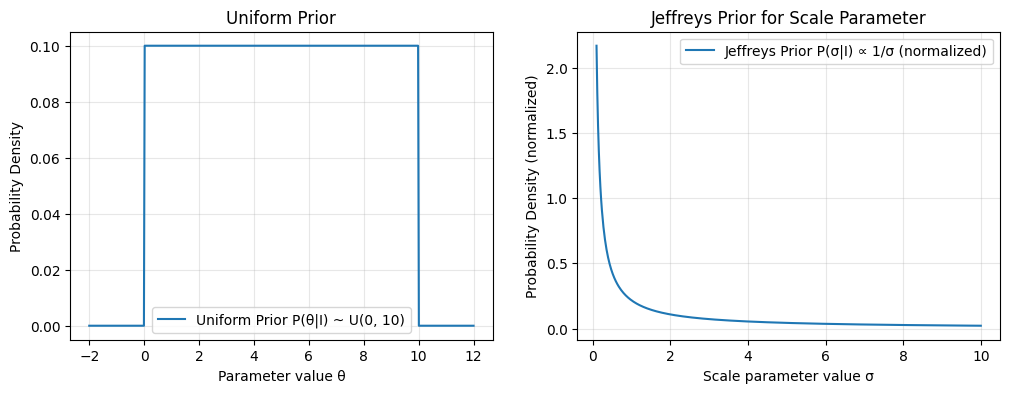

In [18]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# 1. Uniform Prior
ax = axs[0]
x_uniform = np.linspace(-2, 12, 500)
pdf_uniform = st.uniform(loc=0, scale=10).pdf(x_uniform) # Uniform between 0 and 10
ax.plot(x_uniform, pdf_uniform, label='Uniform Prior P(θ|I) ~ U(0, 10)')
ax.set_title('Uniform Prior')
ax.set_xlabel('Parameter value θ')
ax.set_ylabel('Probability Density')
ax.legend()
ax.grid(True, alpha=0.3)

# 2. Jeffreys Prior for scale parameter (visualized as 1/σ on linear scale)
ax = axs[1]
x_jeffreys = np.linspace(0.1, 10, 500)
pdf_jeffreys = 1/x_jeffreys
pdf_jeffreys_norm = pdf_jeffreys / np.trapz(pdf_jeffreys, x_jeffreys) # Normalize for plotting
ax.plot(x_jeffreys, pdf_jeffreys_norm, label='Jeffreys Prior P(σ|I) ∝ 1/σ (normalized)')
ax.set_title('Jeffreys Prior for Scale Parameter')
ax.set_xlabel('Scale parameter value σ')
ax.set_ylabel('Probability Density (normalized)')
ax.legend()
ax.grid(True, alpha=0.3)


*   **Conjugate Priors**: In some cases, the prior and the likelihood can be chosen from families of distributions such that the posterior distribution belongs to the same family as the prior. These are called conjugate priors. They offer mathematical convenience, providing closed-form solutions for the posterior.
    *   **Example: Gaussian Likelihood with Gaussian Prior**: If the likelihood for a parameter $\mu$ is Gaussian, $P(\text{data}|\mu) \sim N(\text{data}; \mu, s_D)$, based on data with sample mean $\bar{x}$ and effective standard deviation of the mean $s = \sigma_D / \sqrt{N_D}$, and the prior for $\mu$ is also Gaussian, $P(\mu|I) \sim N(\mu; \mu_P, \sigma_P)$, then the posterior distribution for $\mu$ is also Gaussian, $P(\mu|\text{data},I) \sim N(\mu; \mu_{post}, \sigma_{post})$, where:
        $$ \sigma_{post}^2 = \left( \frac{1}{\sigma_P^2} + \frac{1}{s^2} \right)^{-1} $$
        $$ \mu_{post} = \sigma_{post}^2 \left( \frac{\mu_P}{\sigma_P^2} + \frac{\bar{x}}{s^2} \right) $$
        The posterior precision ($1/\sigma_{post}^2$) is the sum of the prior precision and the data precision. The posterior mean is a precision-weighted average of the prior mean and the data mean.

The choice of prior should always be justified and its impact on the results assessed, especially if strong claims are made from weakly informative data.

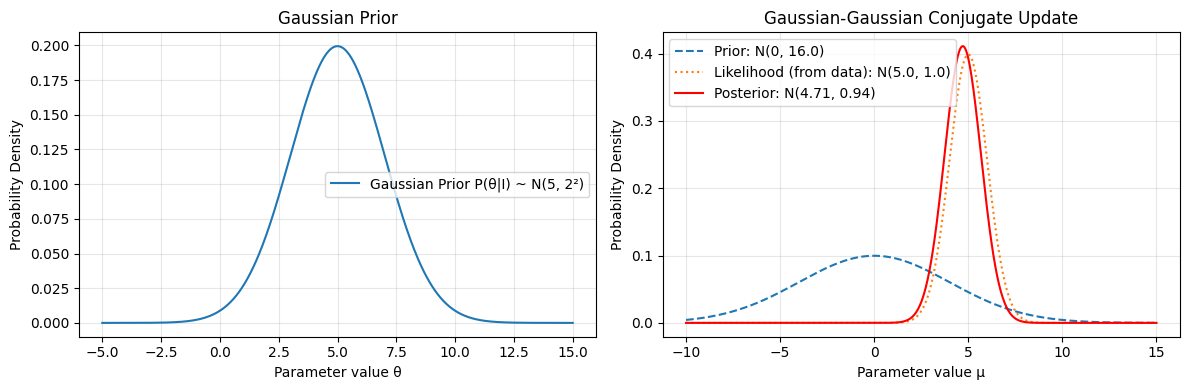

In [20]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# 3. Gaussian Prior
ax = axs[0]
x_gaussian = np.linspace(-5, 15, 500)
pdf_gaussian = st.norm(loc=5, scale=2).pdf(x_gaussian) # Gaussian N(5, 2^2)
ax.plot(x_gaussian, pdf_gaussian, label='Gaussian Prior P(θ|I) ~ N(5, 2²)')
ax.set_title('Gaussian Prior')
ax.set_xlabel('Parameter value θ')
ax.set_ylabel('Probability Density')
ax.legend()
ax.grid(True, alpha=0.3)

# 4. Gaussian-Gaussian Conjugate Update Example
ax = axs[1]
# Prior: P(μ|I) ~ N(μ_P, σ_P^2)
mu_P, sigma_P = 0, 4.0
prior_dist = st.norm(mu_P, sigma_P)

# Data: Assume we have N_D measurements x_i from N(μ, σ_D^2)
# For simplicity, let's say we have a sample mean x_bar and know s = σ_D / sqrt(N_D)
x_bar, s = 5.0, 1.0 # Likelihood centered at x_bar, with std. error of mean s
likelihood_dist = st.norm(x_bar, s) # Represents P(data|μ)

# Posterior: P(μ|data,I) ~ N(μ_post, σ_post^2)
precision_P = 1.0 / sigma_P**2
precision_data = 1.0 / s**2
sigma_post_sq = 1.0 / (precision_P + precision_data)
mu_post = sigma_post_sq * (precision_P * mu_P + precision_data * x_bar)
sigma_post = np.sqrt(sigma_post_sq)
posterior_dist = st.norm(mu_post, sigma_post)

x_gg = np.linspace(-10, 15, 500)
ax.plot(x_gg, prior_dist.pdf(x_gg), label=f'Prior: N({mu_P}, {sigma_P**2})', linestyle='--')
ax.plot(x_gg, likelihood_dist.pdf(x_gg), label=f'Likelihood (from data): N({x_bar}, {s**2})', linestyle=':')
ax.plot(x_gg, posterior_dist.pdf(x_gg), label=f'Posterior: N({mu_post:.2f}, {sigma_post**2:.2f})', color='red')
ax.set_title('Gaussian-Gaussian Conjugate Update')
ax.set_xlabel('Parameter value μ')
ax.set_ylabel('Probability Density')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Bayesian Credible Regions (or Intervals)

Once we have the posterior probability distribution $P(\text{hypothesis} | \text{data}, I)$, which tells us the probability of different parameter values (our hypothesis) given the data, we often want to summarize it.

*   **Point Estimates**: We might report the **Maximum A Posteriori (MAP)** value (the mode of the posterior), the **mean**, or the **median** of the posterior distribution as a single best guess for our parameter.

*   **Credible Regions**: More comprehensively, we define a **credible region** (or credible interval for a single parameter) that contains a certain amount of the posterior probability, for example, 90% or 95%.
    *   A $X\%$ credible region is an interval $[a, b]$ such that $\int_a^b P(\text{parameter} | \text{data}, I) d(\text{parameter}) = X/100$.
    *   **Interpretation**: A $X\%$ credible region means there is a $X\%$ probability that the true value of the parameter lies within that interval, given our data and model. This is a direct statement about the parameter's location.

**Crucial Distinction: Credible Regions vs. Frequentist Confidence Intervals**

This interpretation is fundamentally different from a frequentist confidence interval:
*   A **Bayesian $X\%$ credible region** is a statement about the probability of the parameter's value, given the observed data. The interval is fixed, and we assign a probability to the parameter being in it.
*   A **frequentist $X\%$ confidence interval** is constructed such that if we were to repeat the experiment many times, $X\%$ of such *calculated intervals* would contain the true, fixed parameter value. It's a statement about the long-run performance of the interval construction procedure, not directly about the probability of the parameter lying in a *specific, calculated* interval from our single dataset.
For scientists interpreting a single experiment, the Bayesian credible region often aligns more intuitively with the question: \"How likely is the parameter to be in this range, based on my data?\"

**Types of Credible Regions**

Credible regions are not unique. For a given probability level (e.g., 90%), common ways to define the interval include:
*   **Equal-Tailed Interval (or Central Credible Interval)**: This interval is defined by cutting off $(100-X)/2\%$ of the probability from each tail of the posterior distribution. For example, a 90% equal-tailed interval excludes 5% from the lower tail and 5% from the upper tail. This is often easy to compute.
*   **Highest Posterior Density (HPD) Interval**: This interval is constructed such that all points inside it have a higher posterior probability density than any point outside it. It is the shortest possible interval containing $X\%$ of the probability. While conceptually useful, it can be more complex to calculate, especially for asymmetric or multimodal posteriors.

For simplicity in our example, we will focus on the equal-tailed interval.

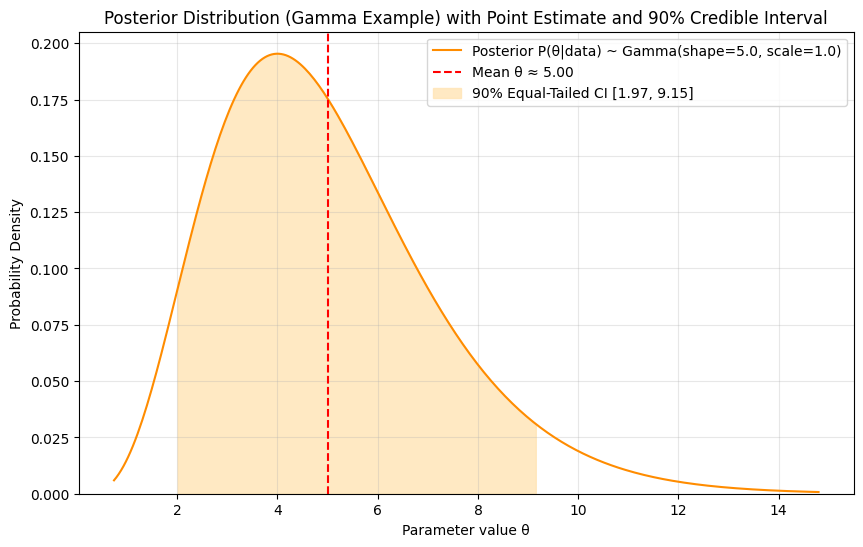

Assumed Posterior Distribution: Gamma(shape=5.0, scale=1.0)
Mean of the posterior (point estimate): 5.00
90% Equal-Tailed Credible Interval for θ: [1.97, 9.15]


In [26]:
# Simple Example: Illustrating a Credible Interval
# Assume we have obtained a posterior distribution for a parameter θ.
# For this illustration, let's use a Gamma distribution as our posterior.
# P(θ|data, I) ~ Gamma(shape=a, scale=b)

shape_param = 5.0  # Example shape parameter for the Gamma posterior
scale_param = 1.0  # Example scale parameter for the Gamma posterior
# For scipy.stats.gamma, 'a' is the shape parameter. 'scale' is the scale parameter.
posterior_dist = st.gamma(a=shape_param, scale=scale_param)

# Values for plotting the PDF
# Plot from near 0 up to a high percentile to see the shape
theta_values = np.linspace(posterior_dist.ppf(0.001), posterior_dist.ppf(0.999), 300)
posterior_pdf_values = posterior_dist.pdf(theta_values)

plt.figure(figsize=(10, 6))
plt.plot(theta_values, posterior_pdf_values, label=f'Posterior P(θ|data) ~ Gamma(shape={shape_param:.1f}, scale={scale_param:.1f})', color='darkorange')

# Point Estimate: Mean of the posterior
mean_theta = posterior_dist.mean()
plt.axvline(mean_theta, color='red', linestyle='--', label=f'Mean θ ≈ {mean_theta:.2f}')

# 90% Equal-Tailed Credible Interval
confidence_level = 0.90
lower_bound, upper_bound = posterior_dist.interval(confidence_level)
plt.fill_between(theta_values, posterior_pdf_values,
                 where=(theta_values >= lower_bound) & (theta_values <= upper_bound),
                 color='moccasin', alpha=0.8,
                 label=f'{confidence_level*100:.0f}% Equal-Tailed CI [{lower_bound:.2f}, {upper_bound:.2f}]')

plt.title('Posterior Distribution (Gamma Example) with Point Estimate and 90% Credible Interval')
plt.xlabel('Parameter value θ')
plt.ylabel('Probability Density')
plt.legend()
plt.grid(True, alpha=0.3)
plt.ylim(bottom=0)
plt.show()

print(f"Assumed Posterior Distribution: Gamma(shape={shape_param}, scale={scale_param})")
print(f"Mean of the posterior (point estimate): {mean_theta:.2f}")
print(f"{confidence_level*100:.0f}% Equal-Tailed Credible Interval for θ: [{lower_bound:.2f}, {upper_bound:.2f}]")

## 2.1. Counting experiment: what does Reverend Bayes say about it...

$$\Large P(\text{hypothesis} | \text{data}) = P(\lambda | k) \propto P(k | \lambda) P(\lambda) $$

where we ignored the evidence since its just a normalization constant for parameter estimation.

### 2.1.1. Assigning a prior belief on the source luminosity (and therefore its expected counts, $\lambda$)

We need to choose a prior $P(\lambda | I)$.

**Option 1: Uniform Prior over a finite range (Principle of Indifference)**
We may have a constraint - that $\lambda$ cannot be above 20 because that would make it an AGN, and we know from other measurements that its not (this is background information $I$):

$$\Large P(\lambda | I) = \begin{cases} C & 0\leq \lambda < 20 \\ 0 & \text{elsewhere} \end{cases}$$

The constant $C$ would be $1/20$ to normalize the prior. However, since we are interested in the shape of the posterior $P(\lambda | k) \propto P(k | \lambda) P(\lambda)$, we can often absorb normalization constants.

Then using the Poisson likelihood as in the frequentist approach:

$$\Large P(\lambda | k) \propto P(k | \lambda) P(\lambda) \propto \begin{cases} \dfrac{\lambda^k e^{-\lambda}}{k!}  & 0\leq \lambda < 20 \\ 0 & \text{elsewhere} \end{cases}$$

**Option 2: Uniform (Improper) Prior for $\lambda \ge 0$ (Agnostic approach)**
Maybe we have no other information and want to be **agnostic** about $\lambda$ (other than it must be non-negative, as its an expected count):

$$\Large  P(\lambda | I) = \text{const.}, \quad \lambda \ge 0 $$

This is an **improper prior** because its integral over $[0, \infty)$ diverges. However, it can still lead to a proper posterior. Since its just a constant, it does not affect the proportionality for the posterior shape:

$$\Large P(\lambda | k) \propto P(k | \lambda) P(\lambda) \propto P(k | \lambda) \propto \dfrac{\lambda^k e^{-\lambda}}{k!} \quad \text{for } \lambda \ge 0$$

<font size=3><u>**In-class discussion: Are we back to frequentism using uniform priors?**</u><font>

_Discuss with your teammate, then report._

<details>
<summary><b>[Spoiler]</b></summary>
<br>
    No! Bayesian inference is not just frequentism + priors. Even if the formula for the posterior $P(\lambda|k)$ looks proportional to the likelihood $P(k|\lambda)$ when using a flat prior, the interpretation is fundamentally different. 
    The posterior $P(\lambda|k)$ is a probability distribution for the parameter $\lambda$, given the observed data $k$. The likelihood $P(k|\lambda)$ is a probability distribution for the data $k$, given a fixed parameter $\lambda$.
    The posterior $P(\lambda | k) \propto \lambda^k e^{-\lambda}$ (for $k$ fixed, $\lambda \ge 0$) is a probability density function for the continuous quantity $\lambda$. In fact, it is a **Gamma distribution**: specifically, $\text{Gamma}(\text{shape}=k+1, \text{scale}=1)$ or $\text{Gamma}(\alpha=k+1, \beta=1)$ depending on parameterization (e.g., if PDF is $f(x;\alpha,\beta) = \frac{\beta^\alpha x^{\alpha-1}e^{-\beta x}}{\Gamma(\alpha)}$).
<br>

<div class="alert alert-block alert-warning" style="margin-top: 20px">

**Task:**  Compute the posterior values for the trial $\lambda$ values. What is the best-fitting value for $\lambda$?
</div>

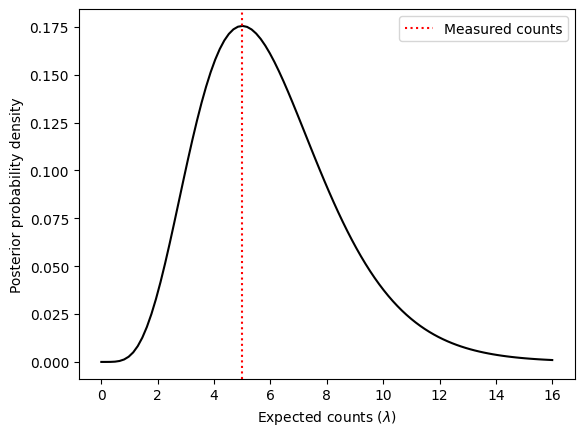

In [6]:
measure_counts = 5.0
lambda_values = np.linspace(0, int(measure_counts*3)+1, 100)
posteriors = st.poisson.pmf(measure_counts, lambda_values)

plt.figure()
plt.plot(lambda_values, posteriors, "k-")
plt.xlabel("Expected counts ($\lambda$)")
plt.ylabel("Posterior probability density")
plt.axvline(5.0, color="r", ls=":", label="Measured counts")
plt.legend(loc="upper right")
plt.show()